In [1]:
%%time

from statsmodels.nonparametric.smoothers_lowess import lowess

from pysme.synthesize import synthesize_spectrum
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from astropy.constants import c
from scipy.stats import norm
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os

warnings.filterwarnings('ignore')

CPU times: user 1.96 s, sys: 3.07 s, total: 5.03 s
Wall time: 23.4 s


In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
os.environ['NUMEXPR_MAX_THREADS'] = '40' #change this number using the correct number of cores/threads in jupyter.slurm

In [4]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [5]:
#Prepare catalogue ingestion
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')

In [13]:
wmin_O = 6295 #AA
wmax_O = 6305 #AA
wmin_Na = 5885 #AA
wmax_Na = 5900 #AA
wmin_Al = 3955 #AA
wmax_Al = 3965 #AA
wmin_Al = 3920 #AA Ca H&K
wmax_Al = 3980 #AA Ca H&K

In [7]:
linelist = pd.DataFrame(ValdFile('linelist/3800-6800_long.lin'))

[2025-07-29 11:27:01,276] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


In [9]:
linelist = pd.DataFrame(ValdFile('linelist/3800-6800_long.lin'))
ll = pd.DataFrame(ValdFile('linelist/O_VALD_all.lin'))
# ll_ch = pd.DataFrame(ValdFile('linelist/CH_VALD_all.lin'))
# ll_cn = pd.DataFrame(ValdFile('linelist/CN_VALD_all.lin'))
linelist = pd.concat([linelist, ll.query('6295 < wlcent < 6305 and gflog > -10')])
linelist = LineList(linedata=linelist.sort_values(by='wlcent', ascending=True), medium='air').sort()

print('Number of lines in the linelist: %d' %linelist.species.size)

[2025-07-29 11:27:25,713] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


[2025-07-29 11:27:25,996] [INFO] [vald:loads:174]: Loading VALD file linelist/O_VALD_all.lin


INFO - Loading VALD file linelist/O_VALD_all.lin
Number of lines in the linelist: 2903


In [10]:
pd.DataFrame(linelist).query('species == "O 1"')

,species,wlcent,gflog,excit,j_lo,e_upp,j_up,lande_lower,lande_upper,lande,...,gamvw,depth,reference,couple_lower,term_lower,couple_upper,term_upper,error,atom_number,ionization
2865,O 1,6300.304,-9.776,0.0,2.0,1.9674,2.0,99.0,99.0,99.0,...,0.0,NaN,"NB+ C CNO, Na 1, Mg 1: 5 wl:NIST10 5 ...",LS,2s2.2p4 3P,LS,2s2.2p4 1D,0.07,1.0,1.0


In [11]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [14]:
#SME parallel and init functions

In [42]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include, wl_min, wl_max):

    #SME definitions
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/UVES_ONaAl.txt', level='ERROR')

    sme.cscale_flag = 'cubic' # 'constant'
    # sme.cscale = 1.0
    sme.cscale_type = 'spline+mask'
    sme.fitresults.maxiter = 100

    if 'O 1' in elems_to_include: sme.cscale = 1.0

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = np.ones(wave.size)
    line_regions[sme.spec.data == 0.0] = 0
    line_regions[(sme.spec.data > np.percentile(sme.spec.data, 35)) & (sme.spec.data < np.percentile(sme.spec.data, 75))] = 2
    line_regions = line_regions.astype(int)
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist[(linelist.wlcent > wl_min) & (linelist.wlcent < wl_max)]

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #Fixed values from pysme
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    
    return sme

In [43]:
def sme_parallel(i, input_row, elems_to_include, vrad_flag, ipress, wl_min, wl_max, is_nlte, tol=1e-5):

    #Load data to create SME structures
    if 'Al 1' in elems_to_include:
        spectra = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
        spectra.waveobs = spectra.waveobs * 10.
        spectra.err[spectra.err == 0.0] = 1.0
    
    if 'O 1' in elems_to_include:
        spectra = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
        spectra.waveobs = spectra.waveobs * 10.
        spectra.err[spectra.err == 0.0] = 1.0

    if 'Na 1' in elems_to_include:
        spectra = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
        spectra.waveobs = spectra.waveobs * 10.
        spectra.err[spectra.err == 0.0] = 1.0
        
    wave = spectra.waveobs[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]
    spec = spectra.flux[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]
    uncs = 1./spectra.err[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]

    #Renormalisation for Al
    # if 'Al 1' in elems_to_include: spec = spec/lowess(spec, wave, frac=0.2, it=15)[:, 1]
    # spec = spec + (1. - np.median(spec))

    del spectra

    #input from pysme
    teff = input_row.teff
    logg = input_row.logg
    monh = input_row.monh
    vmic = input_row.vmic
    vmac = input_row.vmac

    sme = sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress = ipress, vrad_bounds = (-1,1), elems_to_include = elems_to_include, wl_min=wl_min, wl_max=wl_max)
    del wave, spec, uncs

    sme.abund.update_pattern({'Fe':input_row.fe})
    if 'Al 1' in elems_to_include: sme.abund.update_pattern({'C':input_row.c})

    #NLTE
    # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    if is_nlte and ('Al 1' in elems_to_include): sme.nlte.set_nlte('Al', 'nlte_Al_pysme.grd')
    if is_nlte and ('Na 1' in elems_to_include): sme.nlte.set_nlte('Na', 'nlte_Na_pysme.grd')
    if is_nlte and ('O 1'  in elems_to_include): sme.nlte.set_nlte('O' , 'nlte_O_pysme.grd')
    
    #Do the heavy lifting with
    if 'Al 1' in elems_to_include: fitparameters = ['abund Al']
    if 'Na 1' in elems_to_include: fitparameters = ['abund Na']
    if 'O 1'  in elems_to_include: fitparameters = ['abund O']
    
    sme = solve(sme, fitparameters)

    elem, eelem_sme, eelem_fit, n_iter_elem = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations
    eelem_rms = eelem_sme
    
    sme.save('sme_save/uves_elem_%s_lines_%s' %(elems_to_include[0].replace(' ', '').lower(), input_row.spec_id))
    del sme

    if 'Al 1' in elems_to_include:
        columns = ['spec_id', 'al1', 'eal1_rms', 'eal1_sme', 'n_lines_al1', 'min_iters_al1']
        n_lines = 2
    if 'Na 1' in elems_to_include:
        columns = ['spec_id', 'na1', 'ena1_rms', 'ena1_sme', 'n_lines_na1', 'min_iters_na1']
        n_lines = 2
    if 'O 1'  in elems_to_include:
        columns = ['spec_id', 'o1',  'eo1_rms',  'eo1_sme',   'n_lines_o1', 'min_iters_o1' ]
        n_lines = 1
    
    data_to_write = np.vstack((input_row.spec_id, elem, eelem_rms, eelem_sme, n_lines, n_iter_elem)).T
    del elem, eelem_sme, eelem_fit, n_iter_elem

    pd.DataFrame(data=data_to_write, columns=columns).to_csv('abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower(), index=False, header=False, mode='a')
    del data_to_write

    return

In [44]:
def sme_parallel_nlte(i, input_row, elems_to_include, vrad_flag, ipress, wl_min, wl_max, is_nlte, tol=1e-5):

    #Load data to create SME structures
    if 'Al 1' in elems_to_include:
        spectra = ispec.read_spectrum('norm_RV_corr/%s/blue_%s' %(input_row.run, input_row.blue_file))
        spectra.waveobs = spectra.waveobs * 10.
        spectra.err[spectra.err == 0.0] = 1.0
    
    if 'O 1' in elems_to_include:
        spectra = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
        spectra.waveobs = spectra.waveobs * 10.
        spectra.err[spectra.err == 0.0] = 1.0

    if 'Na 1' in elems_to_include:
        spectra = ispec.read_spectrum('norm_RV_corr/%s/red2_%s' %(input_row.run, input_row.red_file))
        spectra.waveobs = spectra.waveobs * 10.
        spectra.err[spectra.err == 0.0] = 1.0
        
    wave = spectra.waveobs[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]
    spec = spectra.flux[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]
    uncs = 1./spectra.err[(spectra.waveobs > wl_min) & (spectra.waveobs < wl_max)]

    #Renormalisation for Al
    if 'Al 1' in elems_to_include: spec = spec/lowess(spec, wave, frac=0.2, it=15)[:, 1]
    spec = spec + (1. - np.median(spec))

    del spectra

    #input from pysme
    teff = input_row.teff
    logg = input_row.logg
    monh = input_row.monh
    vmic = input_row.vmic
    vmac = input_row.vmac

    sme = sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress = ipress, vrad_bounds = (-1,1), elems_to_include = elems_to_include, wl_min=wl_min, wl_max=wl_max)
    del wave, spec, uncs

    sme.abund.update_pattern({'Fe':input_row.fe})
    if 'Al 1' in elems_to_include: sme.abund.update_pattern({'C':input_row.c})

    #NLTE
    # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    if 'Al 1' in elems_to_include: sme.nlte.set_nlte('Al', 'nlte_Al_pysme.grd')
    if 'Na 1' in elems_to_include: sme.nlte.set_nlte('Na', 'nlte_Na_pysme.grd')
    if 'O 1'  in elems_to_include: sme.nlte.set_nlte('O' , 'nlte_O_pysme.grd')
    
    #Do the heavy lifting with
    if 'Al 1' in elems_to_include: fitparameters = ['abund Al']
    if 'Na 1' in elems_to_include: fitparameters = ['abund Na']
    if 'O 1'  in elems_to_include: fitparameters = ['abund O']
    
    sme = solve(sme, fitparameters)

    elem, eelem_sme, eelem_fit, n_iter_elem = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations
    eelem_rms = eelem_sme
    
    sme.save('sme_save/uves_elem_%s_nlte_lines_%s' %(elems_to_include[0].replace(' ', '').lower(), input_row.spec_id))
    del sme

    if 'Al 1' in elems_to_include:
        columns = ['spec_id', 'al1', 'eal1_rms', 'eal1_sme', 'n_lines_al1', 'min_iters_al1']
        n_lines = 2
    if 'Na 1' in elems_to_include:
        columns = ['spec_id', 'na1', 'ena1_rms', 'ena1_sme', 'n_lines_na1', 'min_iters_na1']
        n_lines = 2
    if 'O 1'  in elems_to_include:
        columns = ['spec_id', 'o1',  'eo1_rms',  'eo1_sme',   'n_lines_o1', 'min_iters_o1' ]
        n_lines = 1
    
    data_to_write = np.vstack((input_row.spec_id, elem, eelem_rms, eelem_sme, n_lines, n_iter_elem)).T
    del elem, eelem_sme, eelem_fit, n_iter_elem

    pd.DataFrame(data=data_to_write, columns=columns).to_csv('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower(), index=False, header=False, mode='a')
    del data_to_write

    return

In [66]:
# %%time

# elems_to_include = ['Al 1']
# vrad_flag = 'None'
# ipress = 42000
# tol = 1e-4

# sme = sme_parallel(25, uves.iloc[25], elems_to_include=elems_to_include, vrad_flag=vrad_flag, ipress=ipress, tol=tol, wl_min=wmin_Al, wl_max=wmax_Al, is_nlte=False)

In [67]:
%%time

ipress = 42000
tol = 1e-8

elems_to_include = ['Al 1']
vrad_flag = 'None'

if os.path.exists('abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
    os.system('rm abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower())

Parallel(n_jobs=40, verbose=1)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
                                                     ipress=ipress, tol=tol, wl_min=wmin_Al, wl_max=wmax_Al, is_nlte=False) for i, input_row in uves.iterrows())
!sed -i '1i \spec_id,al1,eal1_rms,eal1_sme,n_lines_al1,min_iters_al1' abunds_merged/uves_lines_al1_merged.csv

# elems_to_include = ['Na 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_Na, wl_max=wmax_Na, is_nlte=False) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,na1,ena1_rms,ena1_sme,n_lines_na1,min_iters_na1' abunds_merged/uves_lines_na1_merged.csv

# elems_to_include = ['O 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_O, wl_max=wmax_O, is_nlte=False) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,o1,eo1_rms,eo1_sme,n_lines_o1,min_iters_o1' abunds_merged/uves_lines_o1_merged.csv

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
/misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A

CPU times: user 1.55 s, sys: 859 ms, total: 2.41 s
Wall time: 52min 39s


[Parallel(n_jobs=40)]: Done 160 out of 160 | elapsed: 52.7min finished


In [19]:
# %%time

# ipress = 42000
# tol = 1e-8

# elems_to_include = ['Al 1']
# vrad_flag = 'whole'
# if os.path.exists('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower())

# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel_nlte)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_Al, wl_max=wmax_Al, is_nlte=True) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,al1_nlte,eal1_nlte_rms,eal1_nlte_sme,n_lines_al1_nlte,min_iters_al1_nlte' abunds_merged/uves_lines_al1_nlte_merged.csv

# elems_to_include = ['Na 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel_nlte)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_Na, wl_max=wmax_Na, is_nlte=True) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,na1_nlte,ena1_nlte_rms,ena1_nlte_sme,n_lines_na1_nlte,min_iters_na1_nlte' abunds_merged/uves_lines_na1_nlte_merged.csv

# elems_to_include = ['O 1']
# vrad_flag = 'fix'
# if os.path.exists('abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower()):
#     os.system('rm abunds_merged/uves_lines_%s_nlte_merged.csv' %elems_to_include[0].replace(' ', '').lower())
# Parallel(n_jobs=50, verbose=1)(delayed(sme_parallel_nlte)(i, input_row, elems_to_include=elems_to_include, vrad_flag=vrad_flag, 
#                                                      ipress=ipress, tol=tol, wl_min=wmin_O, wl_max=wmax_O, is_nlte=True) for i, input_row in uves.iterrows())
# !sed -i '1i \spec_id,o1_nlte,eo1_nlte_rms,eo1_nlte_sme,n_lines_o1_nlte,min_iters_o1_nlte' abunds_merged/uves_lines_o1_nlte_merged.csv

In [18]:
#Plotting 

In [124]:
sme = SME_Structure.load('sme_save/uves_elem_o1_lines_6723486463964965120_3576295_071.sme')

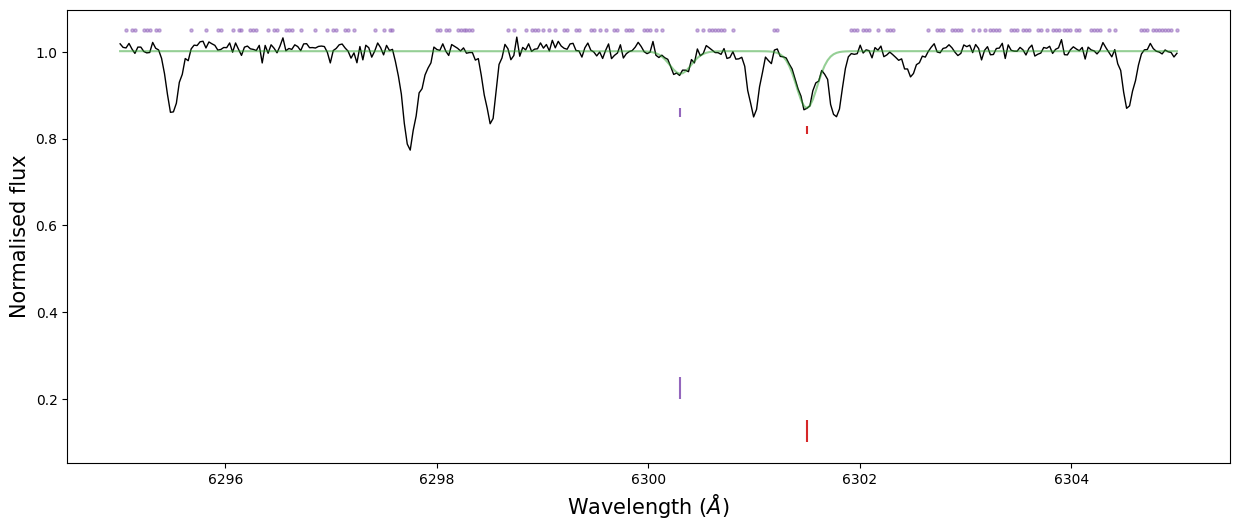

In [125]:
plt.figure(figsize=(15,6), dpi=100)
plt.plot(sme.wave.data, sme.spec.data, lw=1, color='k')
plt.plot(sme.wave.data, sme.synth.data, color='C2', lw=1.5, alpha=0.5)

elem_to_plot = 'O 1'
for wline, species, depth in sme.linelist[['wlcent', 'species', 'depth']]:

    if elem_to_plot in species:
        plt.vlines(wline, 0.2, 0.25, color='C4')
        plt.vlines(wline, 0.85, 0.87, color='C4')
    else:
        plt.vlines(wline, 0.1, 0.15, color='C3')
        plt.vlines(wline, 0.81, 0.83, color='C3')
        # plt.annotate(text='%s' %species, xy=(wline-0.15, 0.05), rotation=90)
    # plt.annotate(text='%2.3f' %depth, xy=(wline-0.15, 0.5), rotation=90)
    
# plt.scatter(sme.wave.data, sme.mask.data, color='grey', s=5, alpha=0.5)
plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2] - 0.95, color='C4', s=5, alpha=0.5)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)

# plt.xlim(3940, 3948)
# plt.xlim(3955, 3965)

# plt.xlim(6297, 6303.0)
# plt.ylim(0.8, 1.05)

# plt.ylim(0.0, 1.1)
plt.show()

In [118]:
sme.fitresults.values, sme.fitresults.uncertainties, sme.fitresults.fit_uncertainties, sme.monh, sme.cscale

(array([9.83136952]),
 array([4.60059294]),
 [0.4919052266483413],
 -2.880014054749,
 array([[1.00189283]]))

In [119]:
sme.cscale_bounds

[-1.7976931348623157e+308, 1.7976931348623157e+308]

In [92]:
uves.rv_red2.values[-1]

-200.19

In [ ]:
#LOWESS regression to fir Al continuum

In [103]:
%%time
# 2. Apply LOWESS for continuum fitting
smoothed = lowess(sme.spec.data, sme.wave.data, frac=0.2, it=15)  # frac controls smoothing

CPU times: user 225 ms, sys: 13 µs, total: 225 ms
Wall time: 227 ms


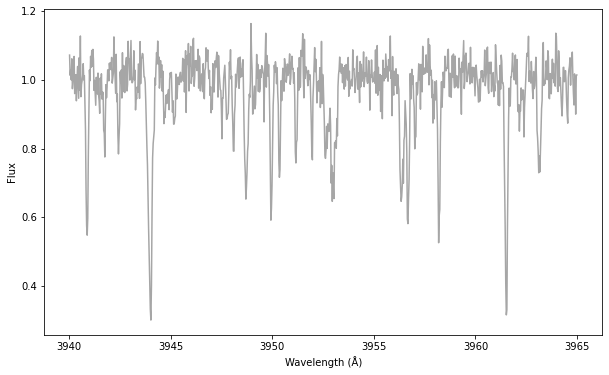

In [104]:
# 3. Plot the original spectrum and the fitted continuum
plt.figure(figsize=(10, 6))
plt.plot(sme.wave.data, sme.spec.data/smoothed[:, 1], label='Noisy Spectrum', color='gray', alpha=0.7)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.show()